# Dust Attenuation and Emission 

A fundamental assumption of our normal galaxy (i.e., non AGN) modeling in `Lightning` is energy balance: the optical power from starlight attenuated by ISM dust is re-radiated in the infrared. As such we present the dust attenuation and emission models side by side here.

## Imports

In [16]:
import numpy as np

from lightning import Lightning
from lightning.attenuation import CalzettiAtten, ModifiedCalzettiAtten, SMC
from lightning.dust import Graybody, DL07Dust

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ebm-dejavu')
%matplotlib inline

## Attenuation

`plightning` currently contains three attenuation options: Calzetti+(2000), "Modified Calzetti" (Noll+2009, including variable UV slope and a 2175 Å bump), and the SMC attenuation curve (Gordon+2003). Adding tabulated attenuation curves is pretty trivial (see `lightning.dust.TabulatedAtten`; the SMC curve is an instance of this class). The Doore+(2021) inclination-dependent attenuation curve is coming soon, pending some more testing of computational enhancements I implemented that might not actually be improvements.

In [6]:
wave = np.logspace(np.log10(0.0912),
                   np.log10(5),
                   200)

calz = CalzettiAtten(wave)
modcalz = ModifiedCalzettiAtten(wave)
smc = SMC(wave)

calz.print_params(verbose=True)
modcalz.print_params(verbose=True)
smc.print_params(verbose=True)


Calzetti
     Parameter  Lo  Hi                      Description
-------------- --- --- --------------------------------
calz_tauV_diff 0.0 inf Optical depth of the diffuse ISM

Total parameters: 1

Modified-Calzetti
      Parameter   Lo  Hi                                              Description
--------------- ---- --- --------------------------------------------------------
mcalz_tauV_diff  0.0 inf                         Optical depth of the diffuse ISM
    mcalz_delta -inf inf      Deviation from the Calzetti+2000 UV power law slope
  mcalz_tauV_BC  0.0 inf Optical depth of the birth cloud in star forming regions

Total parameters: 3

smc
    Parameter  Lo       Hi                      Description
------------- --- -------- --------------------------------
smc_tauV_diff 0.0 100000.0 Optical depth of the diffuse ISM

Total parameters: 1


## SMC and Calzetti

Text(0.5, 1.0, 'Both')

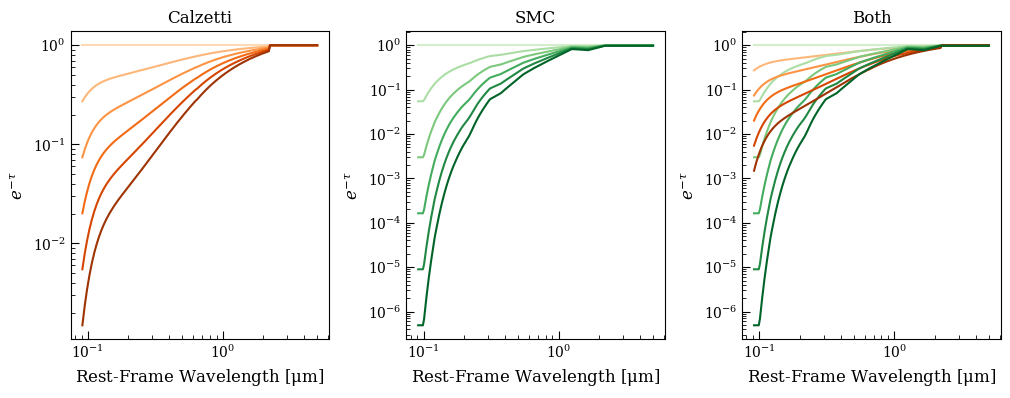

In [12]:
fig, axs = plt.subplots(1,3, figsize=(12,4))
plt.subplots_adjust(wspace=0.3)

tauV_arr = np.linspace(0, 1.5, 6).reshape(-1, 1)
Nmod = len(tauV_arr)

cm_calz = mpl.colormaps['Oranges']
colors_calz = cm_calz(np.linspace(0.2, 0.9, Nmod))

cm_smc = mpl.colormaps['Greens']
colors_smc = cm_smc(np.linspace(0.2, 0.9, Nmod))

calz_models = calz.evaluate(tauV_arr)
smc_models = smc.evaluate(tauV_arr)

for i in np.arange(Nmod):
    axs[0].plot(wave, calz_models[i,:], color=colors_calz[i])
    axs[1].plot(wave, smc_models[i,:], color=colors_smc[i])
    axs[2].plot(wave, calz_models[i,:], color=colors_calz[i])
    axs[2].plot(wave, smc_models[i,:], color=colors_smc[i])

axs[0].set_xscale('log')
axs[0].set_yscale('log')
#axs[0].set_ylim(2e6, 1e11)

axs[0].set_xlabel(r'Rest-Frame Wavelength [$\rm \mu m$]')
axs[0].set_ylabel(r'$e^{- \tau}$')
axs[0].set_title('Calzetti')

axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[1].set_xlabel(r'Rest-Frame Wavelength [$\rm \mu m$]')
axs[1].set_ylabel(r'$e^{- \tau}$')
axs[1].set_title('SMC')

axs[2].set_xscale('log')
axs[2].set_yscale('log')

axs[2].set_xlabel(r'Rest-Frame Wavelength [$\rm \mu m$]')
axs[2].set_ylabel(r'$e^{- \tau}$')
axs[2].set_title('Both')

The SMC curve is steeper at UV wavelengths for the same $\tau_V$. It's used as the default curve for the AGN polar dust model. 

## Modified Calzetti

The main parameters here are the $V-$band optical depth (as above) and $\delta$ the deviation of the UV slope from the Calzetti value. The model also ostensibly allows for extra attenuation for young stars that have not yet blown away their birth cloud ($\tau_{V, \rm BC}$) but this is not currently implemented, so that parameter doesn't do anything. Working on coming up with a solution I like for flexibly allowing differential attenuation based on stellar age (this is also an issue that affects the Doore+2021 model).

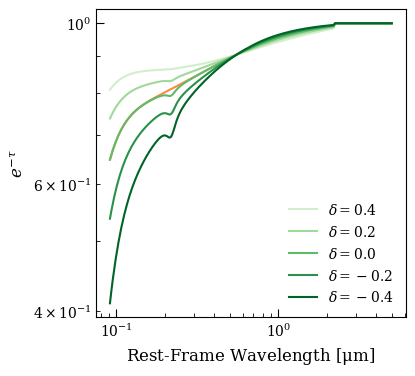

In [41]:
fig, axs = plt.subplots(figsize=(4,4))
plt.subplots_adjust(wspace=0.3)

param_arr = np.array([[0.1, 0.4, 0.0],
                      [0.1, 0.2, 0.0],
                      [0.1, 0.0, 0.0],
                      [0.1, -0.2, 0.0],
                      [0.1, -0.4, 0.0]])
                      
Nmod = param_arr.shape[0]

cm_calz = mpl.colormaps['Oranges']
color_calz = cm_calz(0.5)

cm_modcalz = mpl.colormaps['Greens']
colors_modcalz = cm_smc(np.linspace(0.2, 0.9, Nmod))

calz_models = calz.evaluate(param_arr[:,0])
modcalz_models = modcalz.evaluate(param_arr)

axs.plot(wave, calz_models[0,:], color=color_calz)

for i in np.arange(Nmod):
    axs.plot(wave, modcalz_models[i,:], color=colors_modcalz[i], label=r'$\delta = %.1f$' % (param_arr[i,1]))

axs.set_xscale('log')
axs.set_yscale('log')

axs.set_xlabel(r'Rest-Frame Wavelength [$\rm \mu m$]')
axs.set_ylabel(r'$e^{- \tau}$')
axs.legend(loc='lower right')

The modified Calzetti model is in green, where lighter $\rightarrow$ darker colors indicate $\delta$ changing from positive to negative.
The strength of the 2175 Å feature is tied to the UV slope parameter, $\delta$. Note that the modified Calzetti model is not exactly equal to the Calzetti model with the same $\tau_V$ when $\delta = 0$, due to the presence of the 2175 Å absorption feature.

## Emission Models

In [20]:
wave_grid = np.logspace(np.log10(1),
                        np.log10(1000),
                        200)
filter_labels = ['IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4',
                 'MIPS_CH1', 
                 'PACS_green', 'PACS_red', 
                 'SPIRE_250', 'SPIRE_350', 'SPIRE_500']

redshift = 0.0

dl07 = DL07Dust(filter_labels,
                redshift=redshift)
gb = Graybody(filter_labels,
              redshift=redshift,
              wave_grid=wave_grid)

dl07.print_params(verbose=True)
gb.print_params(verbose=True)


DL07-Dust
      Parameter     Lo       Hi                                                             Description
--------------- ------ -------- -----------------------------------------------------------------------
dl07_dust_alpha  -10.0      4.0                  Radiation field intensity distribution power law index
dl07_dust_U_min    0.1     25.0                                       Radiation field minimum intensity
dl07_dust_U_max 1000.0 300000.0                                       Radiation field maximum intensity
dl07_dust_gamma    0.0      1.0 Fraction of dust mass exposed to radiation field intensity distribution
dl07_dust_q_PAH 0.0047   0.0458                            Fraction of dust mass composed of PAH grains

Total parameters: 5

GrayBody-Dust
Parameter   Lo     Hi                      Description
--------- ---- ------ --------------------------------
  gb_lam0 10.0 1000.0 Wavelength of unit optical depth
  gb_beta  0.1    5.0    Optical depth power law index
     

### Draine and Li (2017)

The Draine and Li model carries around its own wavelength grid due to some artifact of how the models were constructed in IDL `Lightning`. I should aee an option to interpolate it to some other grid for consistency with every other model class...

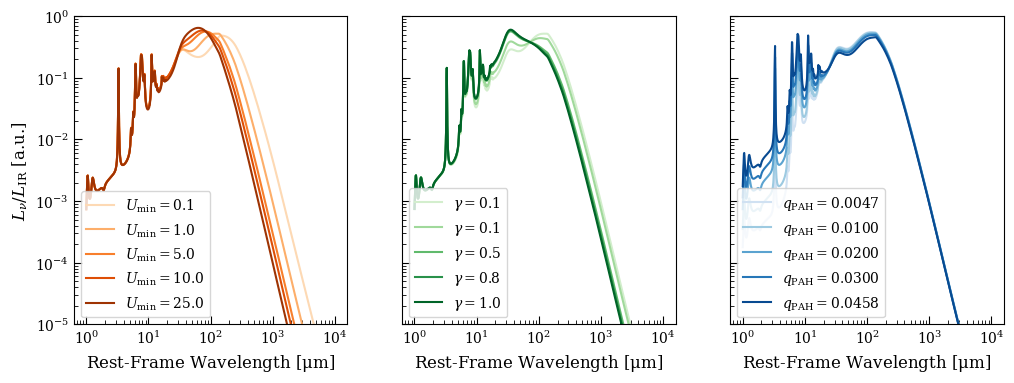

In [46]:
fig, axs = plt.subplots(1,3, figsize=(12,4))

var_umin = np.array([[2, 0.1, 3e5, 0.05, 0.02],
                     [2, 1, 3e5, 0.05, 0.02],
                     [2, 5, 3e5, 0.05, 0.02],
                     [2, 10, 3e5, 0.05, 0.02],
                     [2, 25, 3e5, 0.05, 0.02]])

var_gamma = np.array([[2, 1, 3e5, 0.05, 0.02],
                     [2, 1, 3e5, 0.1, 0.02],
                     [2, 1, 3e5, 0.5, 0.02],
                     [2, 1, 3e5, 0.75, 0.02],
                     [2, 1, 3e5, 1.0, 0.02]])

var_qpah = np.array([[2, 1, 3e5, 0.05, 0.0047],
                     [2, 1, 3e5, 0.05, 0.01],
                     [2, 1, 3e5, 0.05, 0.02],
                     [2, 1, 3e5, 0.05, 0.03],
                     [2, 1, 3e5, 0.05, 0.0458]])

mod_var_umin, L_var_umin = dl07.get_model_lnu_hires(var_umin)
mod_var_gamma, L_var_gamma = dl07.get_model_lnu_hires(var_gamma)
mod_var_qpah, L_var_qpah = dl07.get_model_lnu_hires(var_qpah)

Nmod = var_umin.shape[0]

cm_umin = mpl.colormaps['Oranges']
colors_umin = cm_umin(np.linspace(0.2, 0.9, Nmod))

cm_gamma = mpl.colormaps['Greens']
colors_gamma = cm_gamma(np.linspace(0.2, 0.9, Nmod))

cm_qpah = mpl.colormaps['Blues']
colors_qpah = cm_qpah(np.linspace(0.2, 0.9, Nmod))

for i in np.arange(Nmod):

    axs[0].plot(dl07.wave_grid_rest, dl07.nu_grid_rest * mod_var_umin[i,:] / L_var_umin[i], color=colors_umin[i], label=r'$U_{\rm min} = %.1f$' % (var_umin[i,1]))
    axs[1].plot(dl07.wave_grid_rest, dl07.nu_grid_rest * mod_var_gamma[i,:] / L_var_gamma[i], color=colors_gamma[i], label=r'$\gamma = %.1f$' % (var_gamma[i,3]))
    axs[2].plot(dl07.wave_grid_rest, dl07.nu_grid_rest * mod_var_qpah[i,:] / L_var_qpah[i], color=colors_qpah[i], label=r'$q_{\rm PAH} = %.4f$' % (var_qpah[i,4]))

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel(r'Rest-Frame Wavelength [$\rm \mu m$]')
axs[0].set_ylabel(r'$L_\nu / L_{\rm IR}$ [a.u.]')
axs[0].set_ylim(1e-5, 1)
axs[0].legend(loc='lower left', frameon=True)
#axs[0].set_title(r'$U_{\rm min}=0.1\rightarrow25$')

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'Rest-Frame Wavelength [$\rm \mu m$]')
axs[1].set_yticklabels([])
axs[1].set_ylim(1e-5, 1)
axs[1].legend(loc='lower left', frameon=True)
#axs[1].set_title(r'$\gamma=0.05\rightarrow1$')

axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel(r'Rest-Frame Wavelength [$\rm \mu m$]')
axs[2].set_yticklabels([])
axs[2].set_ylim(1e-5, 1)
axs[2].legend(loc='lower left', frameon=True)
#axs[2].set_title(r'$q_{\rm PAH}=0.0047\rightarrow0.0458$')


In each of the above plots the changing parameter goes from lighter $\rightarrow$ darker lines. Note that in practice the normalization of the model is set by the attenuated power from starlight. 

## Graybody

This model is currently used in our modeling only to represent the re-emission component of the AGN polar dust model.

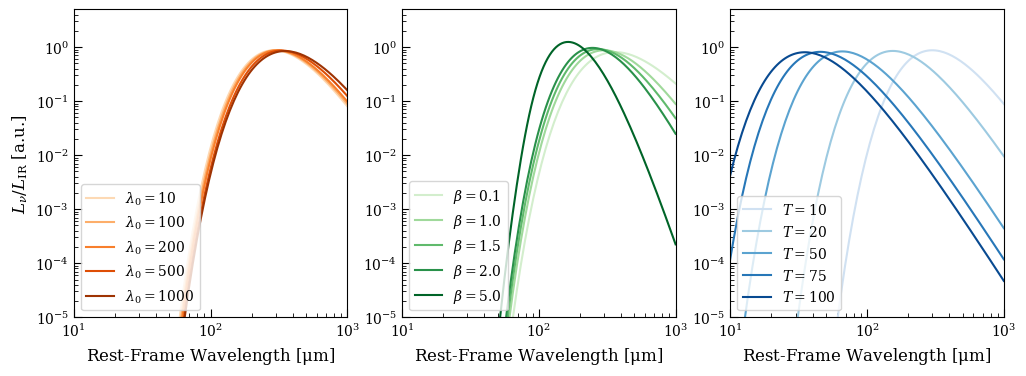

In [50]:
fig, axs = plt.subplots(1,3, figsize=(12,4))

var_lam0 = np.array([[10, 1, 10],
                     [100, 1, 10],
                     [200, 1, 10],
                     [500, 1, 10],
                     [1000, 1, 10]])

var_beta = np.array([[100, 0.1, 10],
                     [100, 1, 10],
                     [100, 1.5, 10],
                     [100, 2, 10],
                     [100, 5, 10]])

var_temp = np.array([[100, 1, 10],
                     [100, 1, 20],
                     [100, 1, 50],
                     [100, 1, 75],
                     [100, 1, 100]])

mod_var_lam0 = gb.get_model_lnu_hires(var_lam0)
mod_var_beta = gb.get_model_lnu_hires(var_beta)
mod_var_temp = gb.get_model_lnu_hires(var_temp)

Nmod = var_umin.shape[0]

cm_lam0 = mpl.colormaps['Oranges']
colors_lam0 = cm_lam0(np.linspace(0.2, 0.9, Nmod))

cm_beta = mpl.colormaps['Greens']
colors_beta = cm_beta(np.linspace(0.2, 0.9, Nmod))

cm_temp = mpl.colormaps['Blues']
colors_temp = cm_temp(np.linspace(0.2, 0.9, Nmod))

for i in np.arange(Nmod):

    axs[0].plot(gb.wave_grid_rest, gb.nu_grid_rest * mod_var_lam0[i,:], color=colors_lam0[i], label=r'$\lambda_0 = %d$' % (var_lam0[i,0]))
    axs[1].plot(gb.wave_grid_rest, gb.nu_grid_rest * mod_var_beta[i,:], color=colors_beta[i], label=r'$\beta = %.1f$' % (var_beta[i,1]))
    axs[2].plot(gb.wave_grid_rest, gb.nu_grid_rest * mod_var_temp[i,:], color=colors_temp[i], label=r'$T = %d$' % (var_temp[i,2]))

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel(r'Rest-Frame Wavelength [$\rm \mu m$]')
axs[0].set_ylabel(r'$L_\nu / L_{\rm IR}$ [a.u.]')
axs[0].set_ylim(1e-5, 5)
axs[0].set_xlim(10, 1000)
#axs[0].set_title(r'$\lambda_{0}=10\rightarrow1000~\rm \mu m$')
axs[0].legend(loc='lower left', frameon=True)

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'Rest-Frame Wavelength [$\rm \mu m$]')
axs[1].set_ylim(1e-5, 5)
axs[1].set_xlim(10, 1000)
#axs[1].set_title(r'$\beta=0.1\rightarrow5$')
axs[1].legend(loc='lower left', frameon=True)


axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel(r'Rest-Frame Wavelength [$\rm \mu m$]')
axs[2].set_ylim(1e-5, 5)
axs[2].set_xlim(10, 1000)
#axs[2].set_title(r'$T=10\rightarrow100~\rm K$')
axs[2].legend(loc='lower left', frameon=True)


Again, for energy balance the model should be normalized to the total attenuated power.